# Programming HW
## Jack's Car Rental
1. with Policy Iteration
2. with Value Iteration
3. discussion

### initializing

#### install requirements

In [1]:
!pip install seaborn

#### import libs

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from scipy.stats import poisson


## 1. Policy Iteration

#### initializing variables

In [3]:
# hparams
MAX_STEP = 10
STATE_NUM = 21
gamma = 0.9
eval_error = 0.01

# Model
policy = np.zeros((STATE_NUM, STATE_NUM))
value = np.zeros((STATE_NUM, STATE_NUM))
actions = list(range(-5, 6))

def get_state_reward(s, mu):
  reward = 10 * np.arange(s+1)
  p = poisson.pmf(np.arange(s+1), mu)
  return reward.dot(p)

reward1 = np.asarray([get_state_reward(s,3) for s in range(21)])
reward2 = np.asarray([get_state_reward(s,4) for s in range(21)])

#### functions

In [4]:
# get transition_probability
def transition_probability(state, ave_req, ave_ret, action):
  p_req = poisson.pmf(np.arange(state+1), ave_req)
  p_ret = poisson.pmf(np.arange(25), ave_ret)
  p = np.outer(p_req, p_ret)
  p_trans = np.asarray([p.trace(x) for x in range(-state, 26)])

  if action == 0:
    p_trans[20] += sum(p_trans[21:])
    return p_trans[:21]
  elif action > 0:
    p_trans[20-action] += sum(p_trans[20-action+1:])
    return np.roll(p_trans, shift=action)[:21]
  else:
    action = -action
    p_trans[action] += sum(p_trans[:action])
    return np.roll(p_trans, shift=-action)[:21]

# get action reward
def get_action_reward(action, s1, s2):
  if action == 0:
    return 0
  elif action >0:
    p = transition_probability(s1, 3, 3, 0)
    cost = np.asarray([i if i < abs(action) else abs(action) for i in range(21)]) * -2
    return cost.dot(p)
  else:
    p = transition_probability(s1, 4, 2, 0)
    cost = np.asarray([i if i < abs(action) else abs(action) for i in range(21)]) * -2
    return cost.dot(p)

# get reward
def get_reward(action, s1, s2):
  return reward1[s1] + reward2[s2] + get_action_reward(action, s1, s2)


#### run

step 1
step 1, iter 1, diff=190.2622
step 1, iter 2, diff=127.7275
step 1, iter 3, diff=78.3935
step 1, iter 4, diff=47.9740
step 1, iter 5, diff=27.4269
step 1, iter 6, diff=14.6272
step 1, iter 7, diff=7.3629
step 1, iter 8, diff=3.5394
step 1, iter 9, diff=1.6368
step 1, iter 10, diff=0.7356
step 1, iter 11, diff=0.3221
step 1, iter 12, diff=0.1391
step 1, iter 13, diff=0.0591
step 1, iter 14, diff=0.0248
step 1, iter 15, diff=0.0103
step 1, iter 16, diff=0.0043


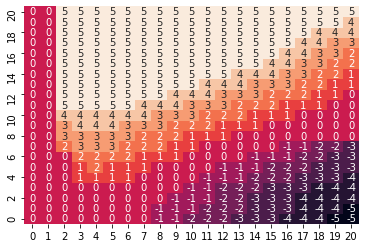

step 2
step 2, iter 1, diff=152.1353
step 2, iter 2, diff=13.7481
step 2, iter 3, diff=9.4176
step 2, iter 4, diff=5.7644
step 2, iter 5, diff=3.4380
step 2, iter 6, diff=2.0302
step 2, iter 7, diff=1.1675
step 2, iter 8, diff=0.6591
step 2, iter 9, diff=0.3673
step 2, iter 10, diff=0.2028
step 2, iter 11, diff=0.1112
step 2, iter 12, diff=0.0607
step 2, iter 13, diff=0.0330
step 2, iter 14, diff=0.0179
step 2, iter 15, diff=0.0097


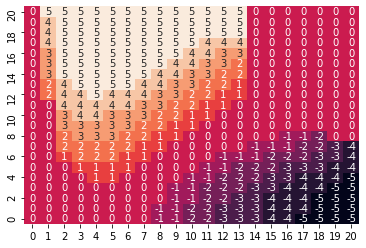

step 3
step 3, iter 1, diff=26.8072
step 3, iter 2, diff=10.7334
step 3, iter 3, diff=4.8303
step 3, iter 4, diff=2.5007
step 3, iter 5, diff=1.3633
step 3, iter 6, diff=0.7518
step 3, iter 7, diff=0.4175
step 3, iter 8, diff=0.2319
step 3, iter 9, diff=0.1288
step 3, iter 10, diff=0.0714
step 3, iter 11, diff=0.0396
step 3, iter 12, diff=0.0219
step 3, iter 13, diff=0.0121
step 3, iter 14, diff=0.0067


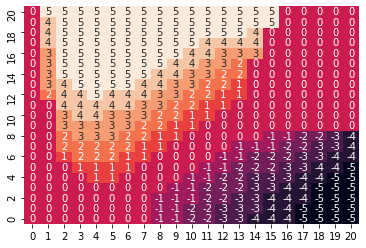

step 4
step 4, iter 1, diff=3.3967
step 4, iter 2, diff=0.4021
step 4, iter 3, diff=0.1414
step 4, iter 4, diff=0.0607
step 4, iter 5, diff=0.0277
step 4, iter 6, diff=0.0134
step 4, iter 7, diff=0.0067


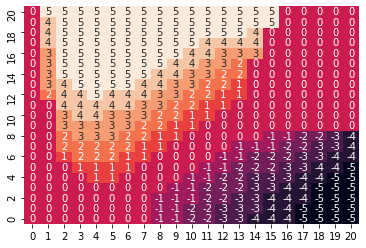

Policy is stable!


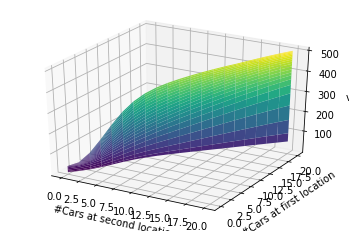

In [5]:
policy_iter_start = time.time()
for step in range(MAX_STEP):
  print(f"step {step+1}")

  # policy evaluation
  i = 0
  while True:
    i += 1
    diff = 0
    for s1 in range(STATE_NUM):
      for s2 in range(STATE_NUM):
        prev_v = value[s1][s2]
        action = int(policy[s1][s2])
        transp1 = transition_probability(s1, 3, 3, -action)
        transp2 = transition_probability(s2, 4, 2, action)
        transp = np.outer(transp1, transp2)
        reward = get_reward(action, s1, s2)
        value[s1][s2] = reward + (gamma * sum((transp * value).flat))

        diff = max(diff, abs(value[s1][s2] - prev_v))
    print(f"step {step+1}, iter {i}, diff={diff:.4f}")
    if diff < eval_error:
      break
  
  # policy improvement
  policy_stable = True
  for s1 in range(STATE_NUM):
      for s2 in range(STATE_NUM):
        optimal_value = -999999
        optimal_action = 0
        for action in actions:
          transp1 = transition_probability(s1, 3, 3, -action)
          transp2 = transition_probability(s2, 4, 2, action)
          transp = np.outer(transp1, transp2)
          reward = get_reward(action, s1, s2)
          candidate = reward + (gamma * sum((transp * value).flat))
          if candidate > optimal_value:
            optimal_value = candidate
            optimal_action = action
        if policy[s1][s2] != optimal_action:
          policy_stable = False
        policy[s1][s2] = optimal_action
    
  # show current policy
  ax = sns.heatmap(policy, annot=True, cbar=False)
  ax.invert_yaxis()
  plt.show()

  if policy_stable is True:
    print("Policy is stable!")
    break

policy_iter_end = time.time()
policy_iter_elap = policy_iter_end - policy_iter_start
ax = plt.axes(projection="3d")
ax.plot_surface(np.array(list(range(21))), np.array(list(range(21))), value, cmap="viridis")
ax.set_xlabel("#Cars at second location")
ax.set_ylabel("#Cars at first location")
ax.set_zlabel("v")
plt.show()

#### results

Policy iteration method takes 64.35 sec to converge.

Final Policy heatmap.


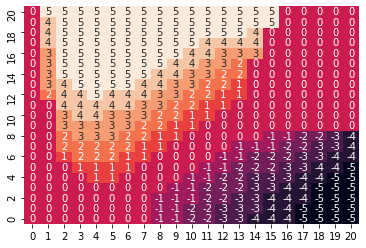


Value graph for the last policy.


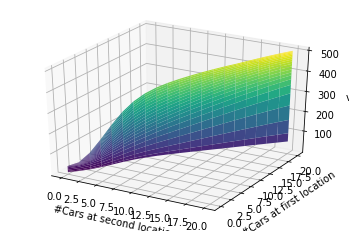

In [6]:
print(f"Policy iteration method takes {policy_iter_elap:.2f} sec to converge.\n")

print("Final Policy heatmap.")
ax = sns.heatmap(policy, annot=True, cbar=False)
ax.invert_yaxis()
plt.show()

print("\nValue graph for the last policy.")
ax = plt.axes(projection="3d")
ax.plot_surface(np.array(list(range(21))), np.array(list(range(21))), value, cmap="viridis")
ax.set_xlabel("#Cars at second location")
ax.set_ylabel("#Cars at first location")
ax.set_zlabel("v")
plt.show()

## 2. Value Iteration

#### initalizing variables

In [7]:
# hparams
MAX_STEP = 100
STATE_NUM = 21
gamma = 0.9
eval_error = 0.01

# Model
policy = np.zeros((STATE_NUM, STATE_NUM))
value = np.zeros((STATE_NUM, STATE_NUM))
actions = list(range(-5, 6))

def get_state_reward(s, mu):
  reward = 10 * np.arange(s+1)
  p = poisson.pmf(np.arange(s+1), mu)
  return reward.dot(p)

reward1 = np.asarray([get_state_reward(s,3) for s in range(21)])
reward2 = np.asarray([get_state_reward(s,4) for s in range(21)])

#### functions

In [8]:
# get transition_probability
def transition_probability(state, ave_req, ave_ret, action):
  p_req = poisson.pmf(np.arange(state+1), ave_req)
  p_ret = poisson.pmf(np.arange(25), ave_ret)
  p = np.outer(p_req, p_ret)
  p_trans = np.asarray([p.trace(x) for x in range(-state, 26)])

  if action == 0:
    p_trans[20] += sum(p_trans[21:])
    return p_trans[:21]
  elif action > 0:
    p_trans[20-action] += sum(p_trans[20-action+1:])
    return np.roll(p_trans, shift=action)[:21]
  else:
    action = -action
    p_trans[action] += sum(p_trans[:action])
    return np.roll(p_trans, shift=-action)[:21]

# get action reward
def get_action_reward(action, s1, s2):
  if action == 0:
    return 0
  elif action >0:
    p = transition_probability(s1, 3, 3, 0)
    cost = np.asarray([i if i < abs(action) else abs(action) for i in range(21)]) * -2
    return cost.dot(p)
  else:
    p = transition_probability(s1, 4, 2, 0)
    cost = np.asarray([i if i < abs(action) else abs(action) for i in range(21)]) * -2
    return cost.dot(p)

# get reward
def get_reward(action, s1, s2):
  return reward1[s1] + reward2[s2] + get_action_reward(action, s1, s2)

#### run

In [9]:
value_iter_start = time.time()
# value iteration
for step in range(MAX_STEP):
  diff = 0
  value_old = value.copy()
  value = np.zeros((STATE_NUM, STATE_NUM))
  for s1 in range(STATE_NUM):
    for s2 in range(STATE_NUM):
      max_value = -999999
      max_action = min(5, s1, MAX_STEP - s2 - 1)
      min_action = max(-5, -s2, -MAX_STEP + s1 + 1)
      for action in range(min_action, max_action + 1):
        transp1 = transition_probability(s1, 3, 3, -action)
        transp2 = transition_probability(s2, 4, 2, action)
        transp = np.outer(transp1, transp2)
        reward = get_reward(action, s1, s2)
        cur_value = reward + (gamma * sum((transp * value_old).flat))
        if cur_value > max_value:
          max_value = cur_value
      value[s1][s2] = max_value
      diff = max(diff, abs(value[s1][s2] - value_old[s1][s2]))
  print(f"step {step+1}, diff={diff:.4f}")
  if diff < eval_error:
    break

# get optimal policy from optimal value function
for s1 in range(STATE_NUM):
  for s2 in range(STATE_NUM):
    optimal_value = -999999
    max_action = min(5, s1, STATE_NUM - s2 - 1)
    min_action = max(-5, -s2, -MAX_STEP + s1 + 1)
    for action in range(min_action, max_action + 1):
      transp1 = transition_probability(s1, 3, 3, -action)
      transp2 = transition_probability(s2, 4, 2, action)
      transp = np.outer(transp1, transp2)
      reward = get_reward(action, s1, s2)
      cur_value = reward + (gamma * sum((transp * value_old).flat))
      if cur_value > optimal_value:
        policy[s1][s2] = action
        optimal_value = cur_value

value_iter_end = time.time()
value_iter_elap = value_iter_end - value_iter_start

step 1, diff=70.0000
step 2, diff=62.9974
step 3, diff=56.5962
step 4, diff=50.3250
step 5, diff=44.0888
step 6, diff=38.4930
step 7, diff=33.5447
step 8, diff=28.9163
step 9, diff=24.4939
step 10, diff=20.3474
step 11, diff=16.5819
step 12, diff=13.2891
step 13, diff=10.4990
step 14, diff=8.1878
step 15, diff=6.3133
step 16, diff=4.8213
step 17, diff=3.6522
step 18, diff=2.7486
step 19, diff=2.0607
step 20, diff=1.5397
step 21, diff=1.1454
step 22, diff=0.8487
step 23, diff=0.6267
step 24, diff=0.4615
step 25, diff=0.3391
step 26, diff=0.2486
step 27, diff=0.1820
step 28, diff=0.1331
step 29, diff=0.0972
step 30, diff=0.0709
step 31, diff=0.0517
step 32, diff=0.0376
step 33, diff=0.0274
step 34, diff=0.0199
step 35, diff=0.0145
step 36, diff=0.0105
step 37, diff=0.0077


#### results

Value iteration method takes 240.80 sec to converge.

Final Policy heatmap.


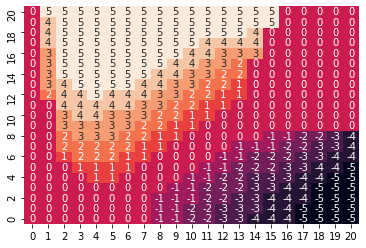


Value graph for the last policy.


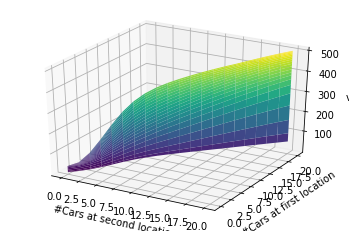

In [10]:
print(f"Value iteration method takes {value_iter_elap:.2f} sec to converge.\n")

print("Final Policy heatmap.")
ax = sns.heatmap(policy, annot=True, cbar=False)
ax.invert_yaxis()
plt.show()

print("\nValue graph for the last policy.")
ax = plt.axes(projection="3d")
ax.plot_surface(np.array(list(range(21))), np.array(list(range(21))), value, cmap="viridis")
ax.set_xlabel("#Cars at second location")
ax.set_ylabel("#Cars at first location")
ax.set_zlabel("v")
plt.show()

## discussion

- Policy iteration과 value iteration 모두 최종적으로 얻은 policy가 동일한 것을 확인할 수 있다. (최종 policy는 heatmap으로 표현)
- 두 방법의 수렴 시간은 policy iteration이 64.35초, value iteration이 240.80초로 policy iteration이 약 176.45초 더 빠르다.
- Policy improve 과정이 존재하지 않는 value iteration 방법이 더 빠르게 수렴할 것으로 기대했지만 결과는 예상과는 다르게 나타났다.
- 그 이유로는 아마도 모든 action에 대해 value 값을 계산하여 최댓값을 구하는 과정이 모든 state에 대해서 이뤄지게 되기 때문으로 유추된다. 모든 action에 대해 고려하는 full-width backup 대신 sample backup을 적용하면 속도가 많이 향상될 것으로 기대된다.